In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
%matplotlib inline

## Data processing

In [2]:
glob.glob("../../datasets/*.tsv")

['../../datasets/enwiki_20161201_reverted_bot2bot.tsv',
 '../../datasets/zhwiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/ptwiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/frwiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/jawiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/dewiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/eswiki_20161001_reverted_bot2bot.tsv']

In [3]:
df_dict = {}
for filename in glob.glob("../../datasets/*.tsv"):
    lang_code = filename[15:17]
    df_dict[lang_code] = pd.read_csv(filename, sep="\t")

In [4]:
for lang, lang_df in df_dict.items():
    print(lang, len(lang_df))

en 1001093
zh 102846
pt 141738
fr 193066
ja 89980
de 137844
es 177368


In [5]:
df_dict['en'][0:2].transpose()

,0,1
rev_id,273691771,136526894
rev_timestamp,20090227173507,20070607044209
rev_user,6505923,4534303
rev_user_text,Kbdankbot,PbBot
rev_page,5040439,3046554
rev_sha1,qj45ne2z4yfexmpaz5wfnbm2yrmqt4j,3xtnw7u4w9h6cg1smw97mqnr1en6a55
rev_minor_edit,False,False
rev_deleted,False,False
rev_parent_id,2.59117e+08,1.20932e+08
archived,False,False


### Combining into one dataframe

In [6]:
df_all = df_dict['en'].copy()
df_all = df_all.drop(df_all.index, axis=0)

for lang, lang_df in df_dict.items():
    lang_df['language'] = lang
    df_all = pd.concat([df_all, lang_df])

In [7]:
df_all['language'].value_counts()

en    1001093
fr     193066
es     177368
pt     141738
de     137844
zh     102846
ja      89980
Name: language, dtype: int64

In [8]:
for lang, lang_df in df_dict.items():
    print(lang, len(lang_df))

en 1001093
zh 102846
pt 141738
fr 193066
ja 89980
de 137844
es 177368


### Namespace type

In [9]:
def namespace_type(item):
    if int(item) == 0:
        return 'article'
    elif int(item) == 14:
        return 'category'
    elif int(item) % 2 == 1:
        return 'other talk'
    else:
        return 'other page'

In [10]:
df_all['namespace_type'] = df_all['page_namespace'].apply(namespace_type)

In [11]:
df_all['namespace_type'].value_counts()

article       1122392
category       365193
other page     226994
other talk     129356
Name: namespace_type, dtype: int64

### Datetime parsing

In [12]:
def get_year(timestamp):
    return timestamp.year

In [13]:
for lang, lang_df in df_dict.items():

    df_dict[lang]['reverting_timestamp_dt'] = pd.to_datetime(df_dict[lang]['reverting_timestamp'], format="%Y%m%d%H%M%S")
    df_dict[lang]['reverted_timestamp_dt'] = pd.to_datetime(df_dict[lang]['rev_timestamp'], format="%Y%m%d%H%M%S")

    df_dict[lang] = df_dict[lang].set_index('reverting_timestamp_dt')

    df_dict[lang]['reverting_timestamp_dt'] = pd.to_datetime(df_dict[lang]['reverting_timestamp'], format="%Y%m%d%H%M%S")

    df_dict[lang]['time_to_revert'] = df_dict[lang]['reverting_timestamp_dt']-df_dict[lang]['reverted_timestamp_dt']
    
    df_dict[lang]['time_to_revert_hrs'] = df_dict[lang]['time_to_revert'].astype('timedelta64[s]')/(60*60)
    
    df_dict[lang]['time_to_revert_days'] = df_dict[lang]['time_to_revert'].astype('timedelta64[s]')/(60*60*24)
    
    df_dict[lang]['reverting_year'] = df_dict[lang]['reverting_timestamp_dt'].apply(get_year)

In [14]:
df_all['reverting_timestamp_dt'] = pd.to_datetime(df_all['reverting_timestamp'], format="%Y%m%d%H%M%S")
df_all['reverted_timestamp_dt'] = pd.to_datetime(df_all['rev_timestamp'], format="%Y%m%d%H%M%S")

df_all = df_all.set_index('reverting_timestamp_dt')

df_all['reverting_timestamp_dt'] = pd.to_datetime(df_all['reverting_timestamp'], format="%Y%m%d%H%M%S")

df_all['time_to_revert'] = df_all['reverting_timestamp_dt']-df_all['reverted_timestamp_dt']

df_all['time_to_revert_hrs'] = df_all['time_to_revert'].astype('timedelta64[s]')/(60*60)

df_all['time_to_revert_days'] = df_all['time_to_revert'].astype('timedelta64[s]')/(60*60*24)

df_all['reverting_year'] = df_all['reverting_timestamp_dt'].apply(get_year)

In [15]:
df_all.reverting_year.value_counts().sort_index()

2004       604
2005      3196
2006     12714
2007     58850
2008    109978
2009    163096
2010    137000
2011    294004
2012    206238
2013    685235
2014     53466
2015     70826
2016     48728
Name: reverting_year, dtype: int64

### Final data format

In [16]:
df_all[0:2].transpose()

reverting_timestamp_dt,2009-02-28 02:19:25,2009-02-10 23:03:37
archived,False,False
language,en,en
page_namespace,0,1
rev_deleted,False,False
rev_id,273691771,136526894
rev_minor_edit,False,False
rev_page,5040439,3046554
rev_parent_id,2.59117e+08,1.20932e+08
rev_revert_offset,1,1
rev_sha1,qj45ne2z4yfexmpaz5wfnbm2yrmqt4j,3xtnw7u4w9h6cg1smw97mqnr1en6a55


## Analysis

### Mean days to revert by language and namespace

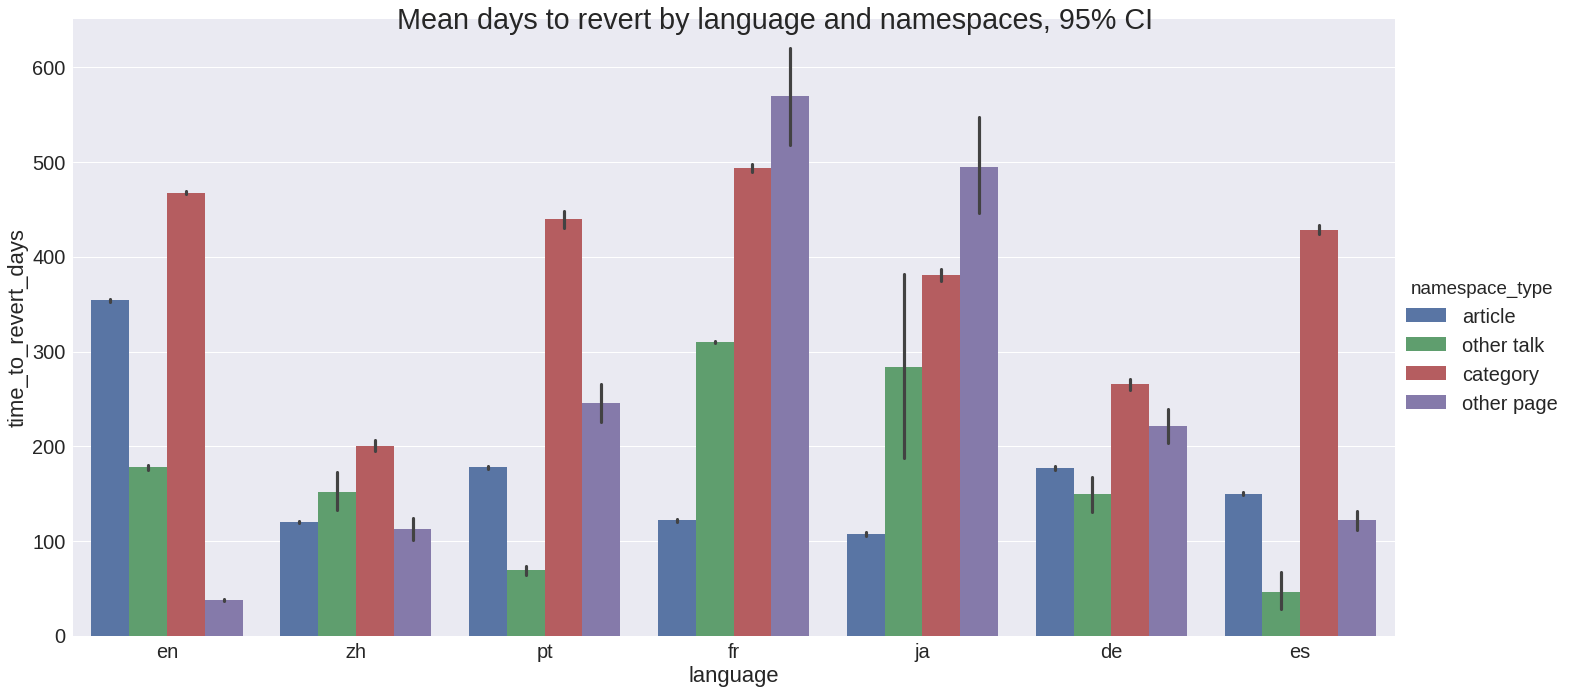

In [17]:
sns.set(font_scale=2)

g = sns.factorplot(data=df_all,
                   x='language',
                   y='time_to_revert_days',
                   hue='namespace_type',
                   kind='bar',
                   size=10,
                   aspect = 2)

plt.suptitle("Mean days to revert by language and namespaces, 95% CI")

### Median days to revert by language and namespace

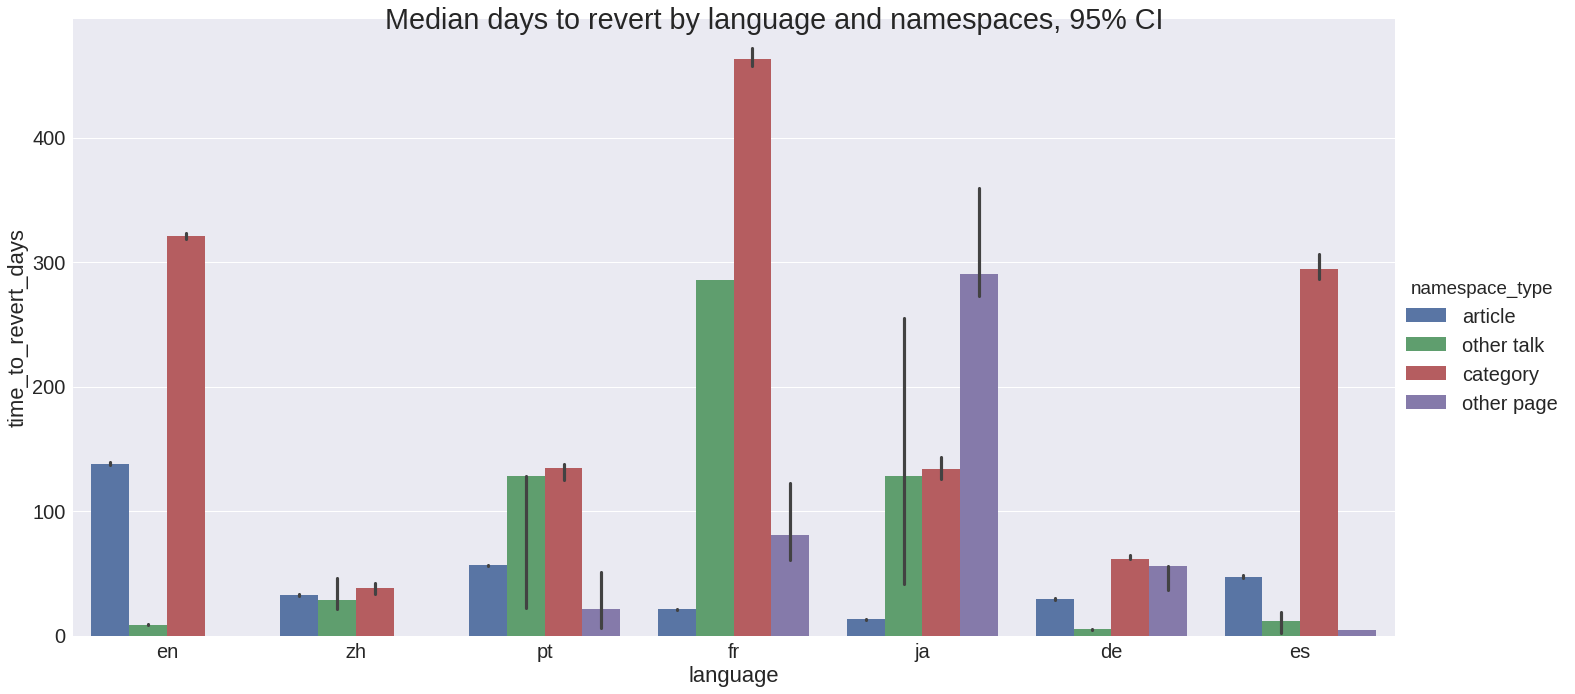

In [18]:
sns.set(font_scale=2)

g = sns.factorplot(data=df_all,
                   x='language',
                   y='time_to_revert_days',
                   hue='namespace_type',
                   kind='bar',
                   estimator=np.median,
                   size=10,
                   aspect = 2)

plt.suptitle("Median days to revert by language and namespaces, 95% CI")

### Mean days to revert by language and year, all namespaces

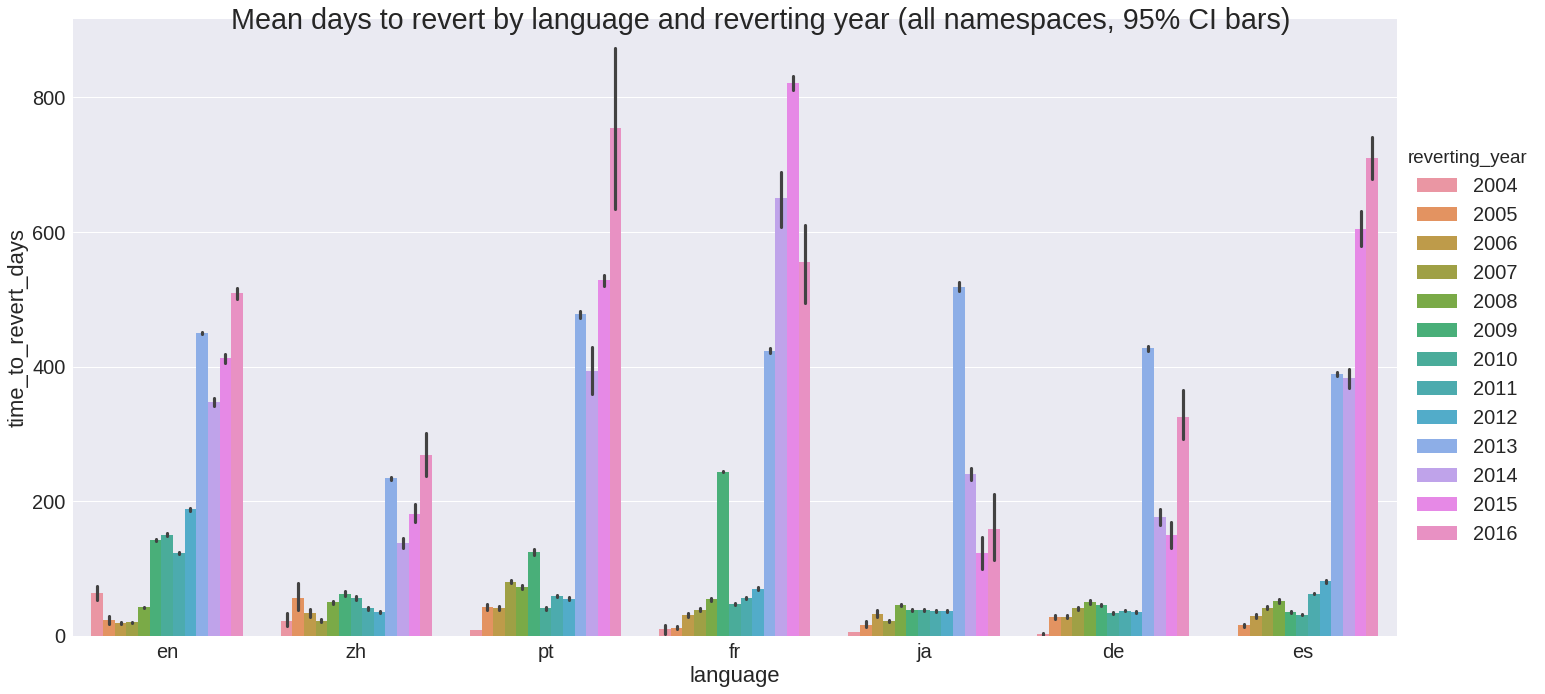

In [19]:
sns.set(font_scale=2)

g = sns.factorplot(data=df_all,
                   x='language',
                   y='time_to_revert_days',
                   hue='reverting_year',
                   kind='bar',
                   size=10,
                   aspect = 2)

plt.suptitle("Mean days to revert by language and reverting year (all namespaces, 95% CI bars)")

### Median days to revert by language and year, all namespaces

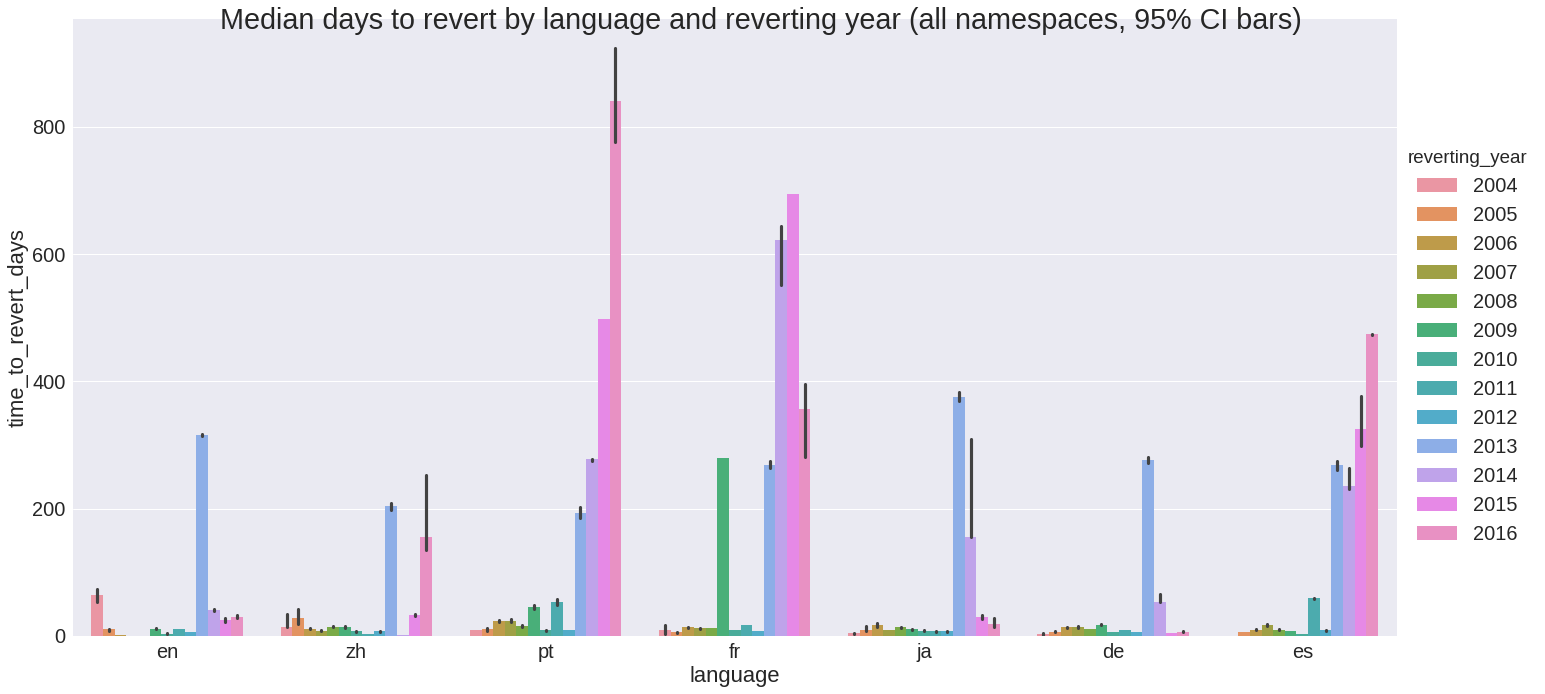

In [20]:
sns.set(font_scale=2)

g = sns.factorplot(data=df_all,
                   x='language',
                   y='time_to_revert_days',
                   hue='reverting_year',
                   kind='bar',
                   estimator=np.median,
                   size=10,
                   aspect = 2)

plt.suptitle("Median days to revert by language and reverting year (all namespaces, 95% CI bars)")

### Mean days to revert by language and year, articles only

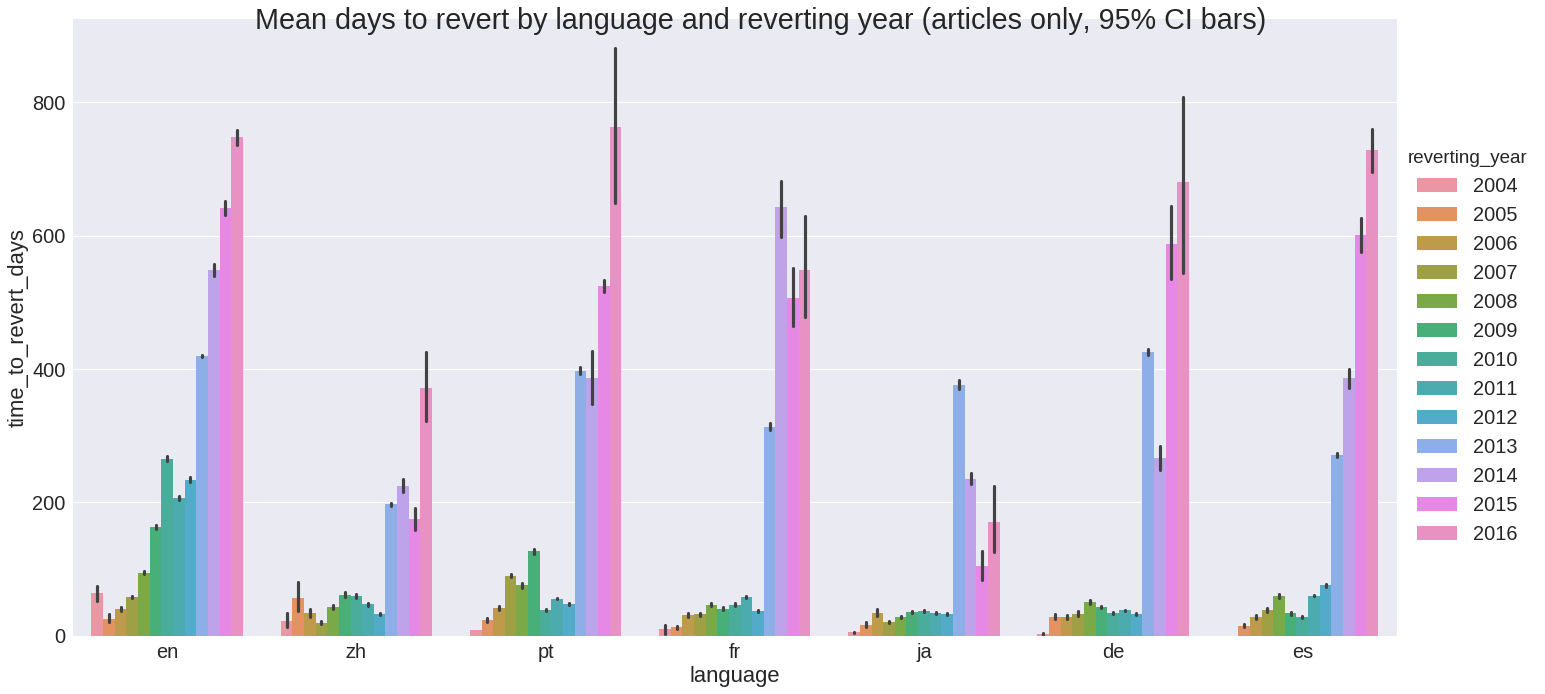

In [21]:
sns.set(font_scale=2)

g = sns.factorplot(data=df_all[df_all['page_namespace']==0],
                   x='language',
                   y='time_to_revert_days',
                   hue='reverting_year',
                   kind='bar',
                   size=10,
                   aspect = 2)

plt.suptitle("Mean days to revert by language and reverting year (articles only, 95% CI bars)")

### Median days to revert by language and year, articles only

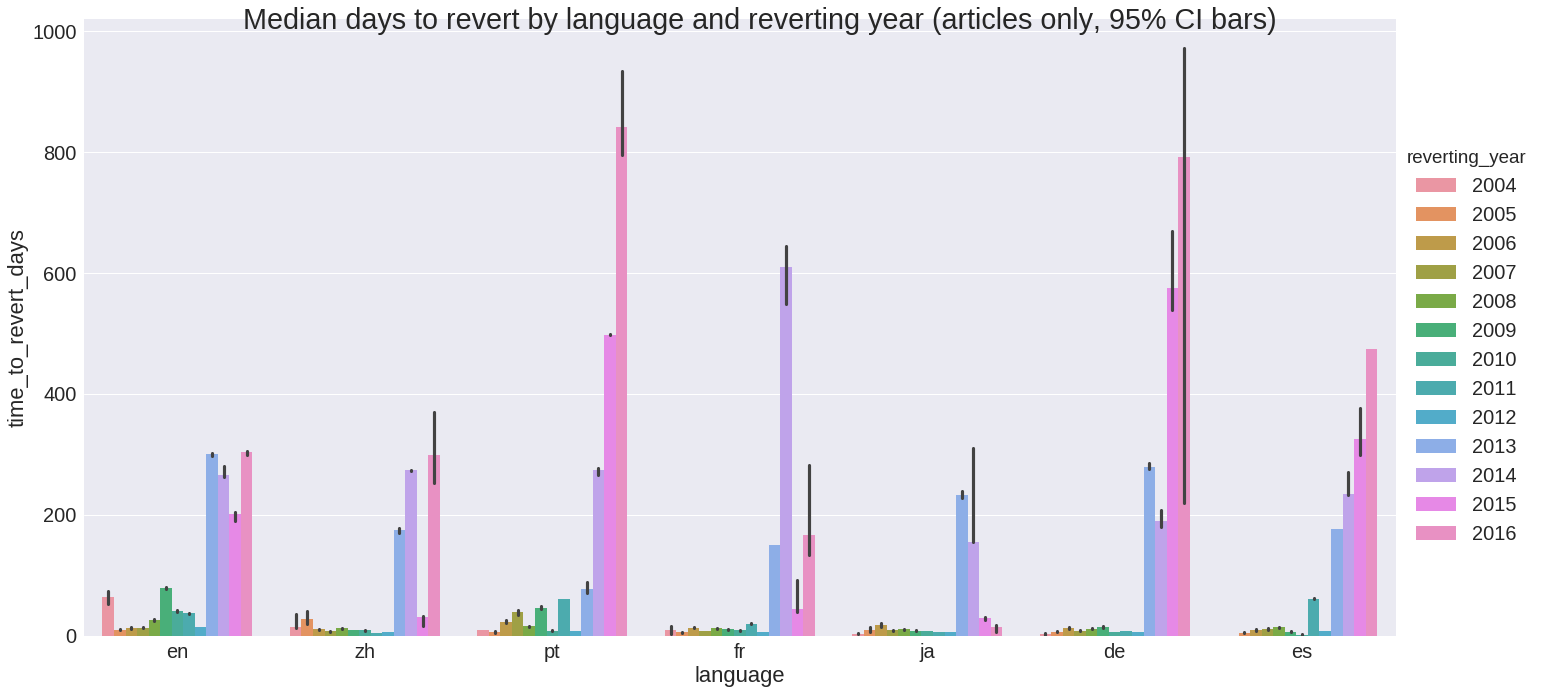

In [22]:
sns.set(font_scale=2)

g = sns.factorplot(data=df_all[df_all['page_namespace']==0],
                   x='language',
                   y='time_to_revert_days',
                   hue='reverting_year',
                   kind='bar',
                   estimator=np.median,                   
                   size=10,
                   aspect = 2)

plt.suptitle("Median days to revert by language and reverting year (articles only, 95% CI bars)")

### Descriptive statistics for time to revert, hours

In [23]:
describe_dict = {}

for lang, lang_df in df_dict.items():
    describe_dict[lang]= df_dict[lang]['time_to_revert_hrs'].describe()
    
    print("language:", lang)
    print(describe_dict[lang])
    print("\n")

language: en
count    1.001093e+06
mean     7.068149e+03
std      1.097299e+04
min      2.777778e-04
25%      3.060722e+01
50%      1.740039e+03
75%      1.058442e+04
max      1.157745e+05
Name: time_to_revert_hrs, dtype: float64


language: zh
count    102846.000000
mean       3131.819786
std        5461.266641
min           0.001111
25%          78.760972
50%         738.368056
75%        5005.667778
max       68876.876667
Name: time_to_revert_hrs, dtype: float64


language: pt
count    141738.000000
mean       5147.610715
std        9497.500147
min           0.000556
25%         170.939722
50%        1419.143611
75%        4180.966944
max       67175.651111
Name: time_to_revert_hrs, dtype: float64


language: fr
count    193066.000000
mean       5809.161689
std        8677.221461
min           0.000278
25%         218.971111
50%        1875.097222
75%        7010.791667
max       79629.037222
Name: time_to_revert_hrs, dtype: float64


language: ja
count    89980.000000
mean      410

### Descriptive statistics for time to revert, days

In [24]:
for lang, lang_df in df_dict.items():
    print("language:", lang)
    print((df_dict[lang]['time_to_revert_hrs']/24).describe())
    print("\n")



language: en
count    1.001093e+06
mean     2.945062e+02
std      4.572079e+02
min      1.157407e-05
25%      1.275301e+00
50%      7.250163e+01
75%      4.410173e+02
max      4.823938e+03
Name: time_to_revert_hrs, dtype: float64


language: zh
count    102846.000000
mean        130.492491
std         227.552777
min           0.000046
25%           3.281707
50%          30.765336
75%         208.569491
max        2869.869861
Name: time_to_revert_hrs, dtype: float64


language: pt
count    141738.000000
mean        214.483780
std         395.729173
min           0.000023
25%           7.122488
50%          59.130984
75%         174.206956
max        2798.985463
Name: time_to_revert_hrs, dtype: float64


language: fr
count    193066.000000
mean        242.048404
std         361.550894
min           0.000012
25%           9.123796
50%          78.129051
75%         292.116319
max        3317.876551
Name: time_to_revert_hrs, dtype: float64


language: ja
count    89980.000000
mean       17

## Plotting histogram distribution of time differences

Note: I'm not 100% sure I'm doing the manual histogram correctly

### Time to revert, articles only, more bins

In [109]:
bins=[0,(1/60),(5/60),(10/60),(30/60),1,2,4,8,12,24,72,(24*7), (24*30), (24*180), (24*365), (24*365*2)]
bin_labels = ["<=1 min",
              "5 mins",
              "10 mins",
              "30 mins",
              "1 hr",
              "2 hrs",
              "4 hrs",
              "8 hrs",
              "12 hrs",
              "24 hrs",
              "3 days",
              "7 days",
              "30 days",
              "180 days",
              "1 year",
              ">2 years"]

In [111]:
hist_counts_dict = {}
hist_bins_dict = {}

for lang, lang_df in df_dict.items():
    #print(lang)
    hist_counts_dict[lang], hist_bins_dict[lang] = np.histogram(lang_df[lang_df['page_namespace']==0]['time_to_revert_hrs'], bins=bins)

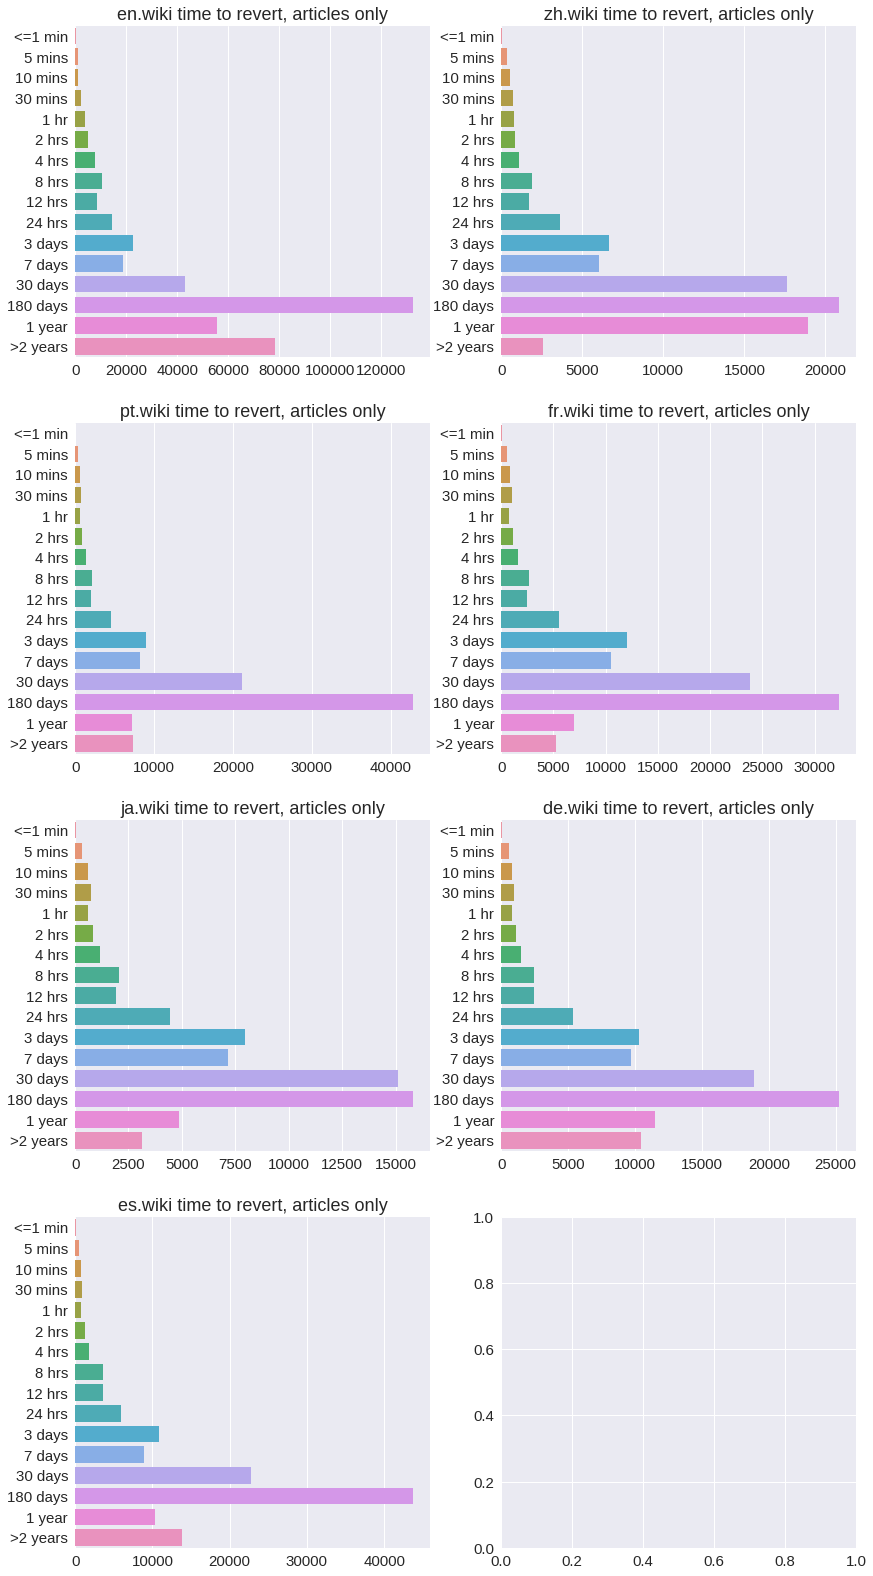

In [112]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=[14,28])

count = 0
for lang, lang_df in df_dict.items():
    row = count // 2
    col = count % 2
    ax_curr = axes[row, col]
    
    hist_counts_curr = hist_counts_dict[lang]
    hist_bins_curr = hist_bins_dict[lang][1:]
    
    sns.barplot(x=hist_counts_curr, y=hist_bins_curr, ax=ax_curr, orient="h")
    txt = ax_curr.set_yticklabels(bin_labels)
    #lt.xticks(rotation='vertical')
    ax_curr.set_title(lang + ".wiki time to revert, articles only")
    count = count + 1

### Time to revert, articles only, fewer bins

In [113]:
bins=[0,(5/60),1,24,(24*7), (24*30), (24*90), (24*180), (24*365), (24*365*2), (24*365*15)]
bin_labels = ["<5 mins",
              "5-60 mins",
              "1-24 hrs",
              "1-7 days",
              "7-30 days",
              "30-90 days",
              "90-180 days",
              "180 days-1 year",
              "1-2 years",
              ">2 years"]

In [115]:
hist_counts_dict = {}
hist_bins_dict = {}

for lang, lang_df in df_dict.items():
    #print(lang)
    hist_counts_dict[lang], hist_bins_dict[lang] = np.histogram(lang_df[lang_df['page_namespace']==0]['time_to_revert_hrs'], bins=bins)

#### No shared x axis

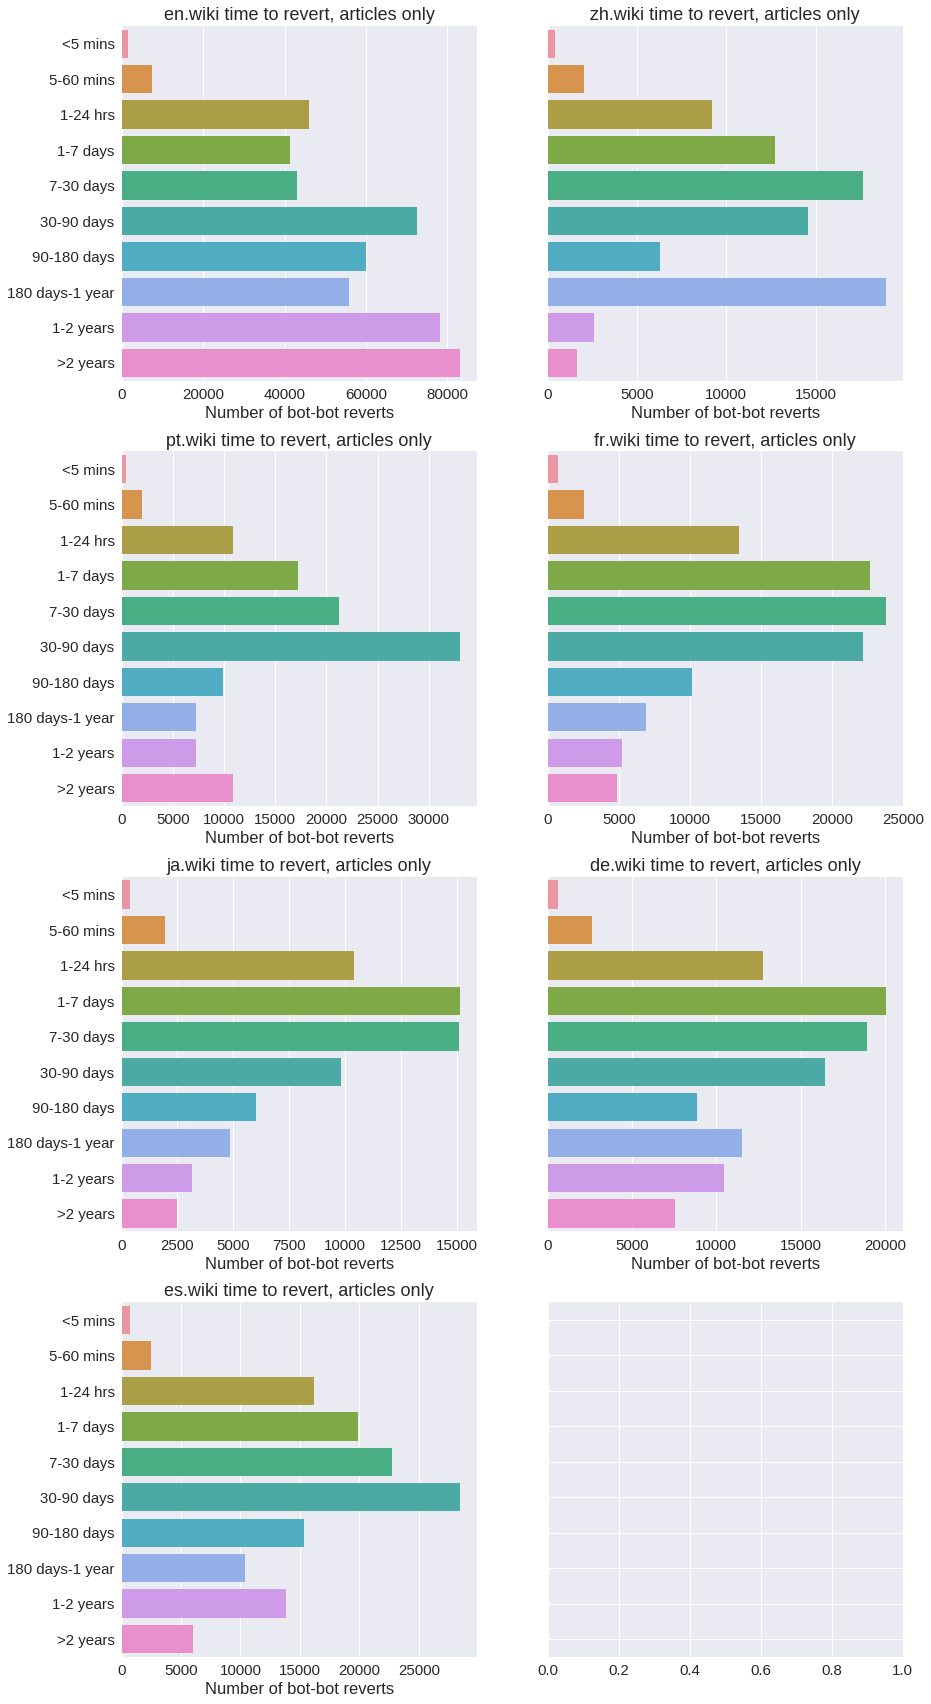

In [116]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=[14,30], sharey=True, sharex=False)

count = 0
for lang, lang_df in df_dict.items():
    row = count // 2
    col = count % 2
    ax_curr = axes[row, col]
    
    hist_counts_curr = hist_counts_dict[lang]
    hist_bins_curr = hist_bins_dict[lang][1:]
    
    sns.barplot(x=hist_counts_curr, y=hist_bins_curr, ax=ax_curr, orient="h")
    txt = ax_curr.set_yticklabels(bin_labels)
    ax_curr.set_xlabel("Number of bot-bot reverts")
    #lt.xticks(rotation='vertical')
    ax_curr.set_title(lang + ".wiki time to revert, articles only")
    count = count + 1

### Time to revert, all namespaces, more bins

In [117]:
bins=[0,(1/60),(5/60),(10/60),(30/60),1,2,4,8,12,24,72,(24*7), (24*30), (24*180), (24*365), (24*365*2)]
bin_labels = ["<=1 min",
              "5 mins",
              "10 mins",
              "30 mins",
              "1 hr",
              "2 hrs",
              "4 hrs",
              "8 hrs",
              "12 hrs",
              "24 hrs",
              "3 days",
              "7 days",
              "30 days",
              "180 days",
              "1 year",
              ">2 years"]

In [118]:
hist_counts_dict = {}
hist_bins_dict = {}

for lang, lang_df in df_dict.items():
    #print(lang)
    hist_counts_dict[lang], hist_bins_dict[lang] = np.histogram(df_dict[lang]['time_to_revert_hrs'], bins=bins)

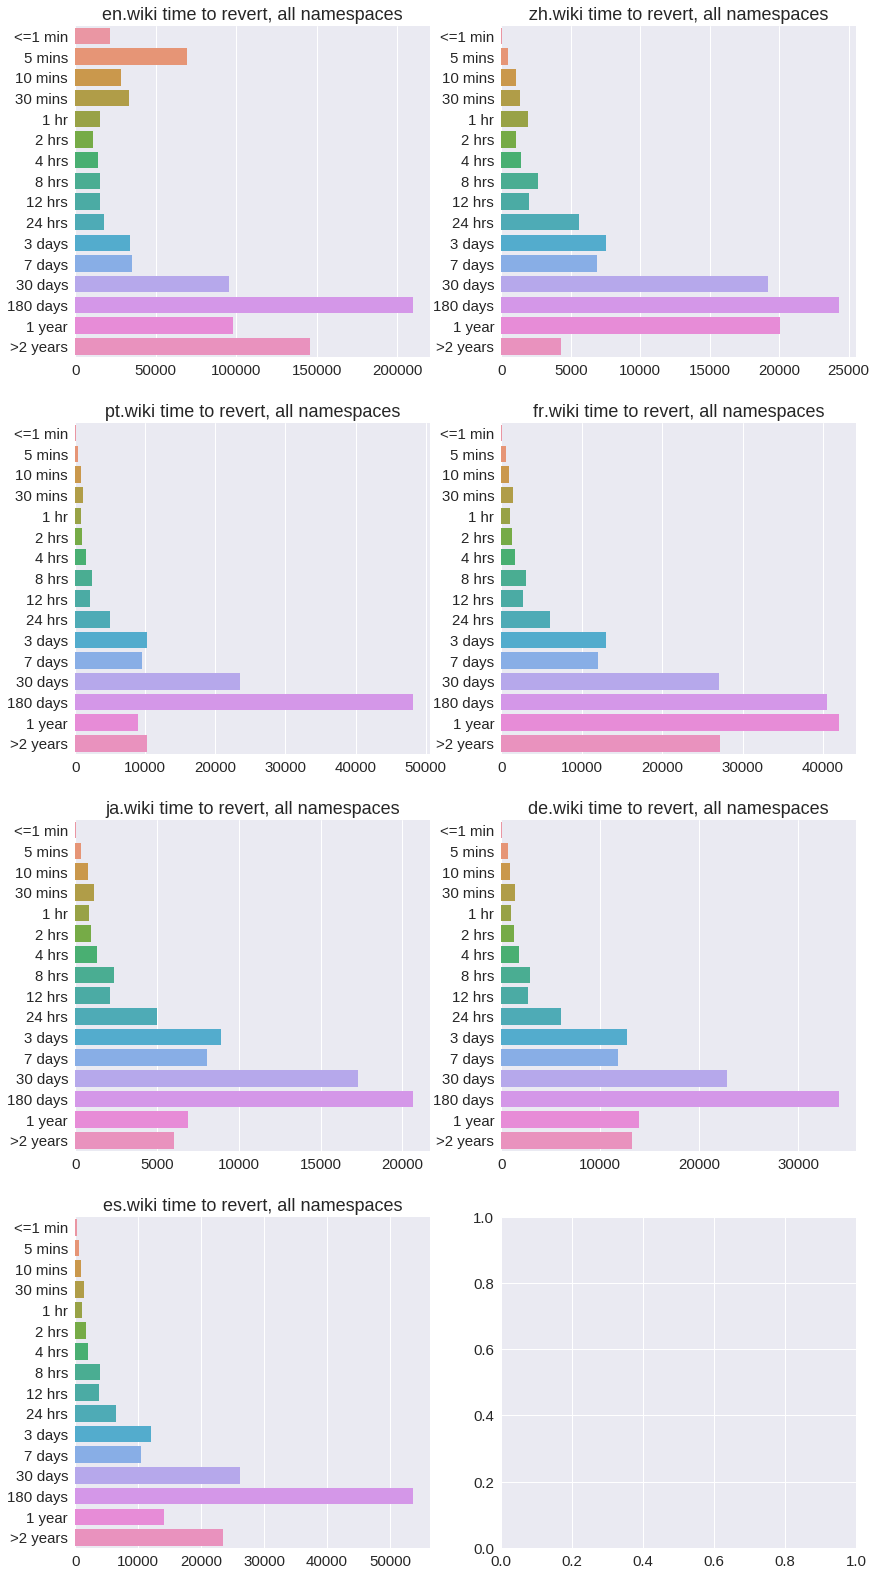

In [119]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=[14,28])

count = 0
for lang, lang_df in df_dict.items():
    row = count // 2
    col = count % 2
    ax_curr = axes[row, col]
    
    hist_counts_curr = hist_counts_dict[lang]
    hist_bins_curr = hist_bins_dict[lang][1:]
    
    sns.barplot(x=hist_counts_curr, y=hist_bins_curr, ax=ax_curr, orient="h")
    txt = ax_curr.set_yticklabels(bin_labels)
    #lt.xticks(rotation='vertical')
    ax_curr.set_title(lang + ".wiki time to revert, all namespaces")
    count = count + 1

### Time to revert, all namespaces, fewer bins

In [120]:
bins=[0,(5/60),1,24,(24*7), (24*30), (24*90), (24*180), (24*365), (24*365*2), (24*365*15)]
bin_labels = ["<5 mins",
              "5-60 mins",
              "1-24 hrs",
              "1-7 days",
              "7-30 days",
              "30-90 days",
              "90-180 days",
              "180 days-1 year",
              "1-2 years",
              ">2 years"]

In [121]:
hist_counts_dict = {}
hist_bins_dict = {}

for lang, lang_df in df_dict.items():
    #print(lang)
    hist_counts_dict[lang], hist_bins_dict[lang] = np.histogram(df_dict[lang]['time_to_revert_hrs'], bins=bins)

#### No shared x axis

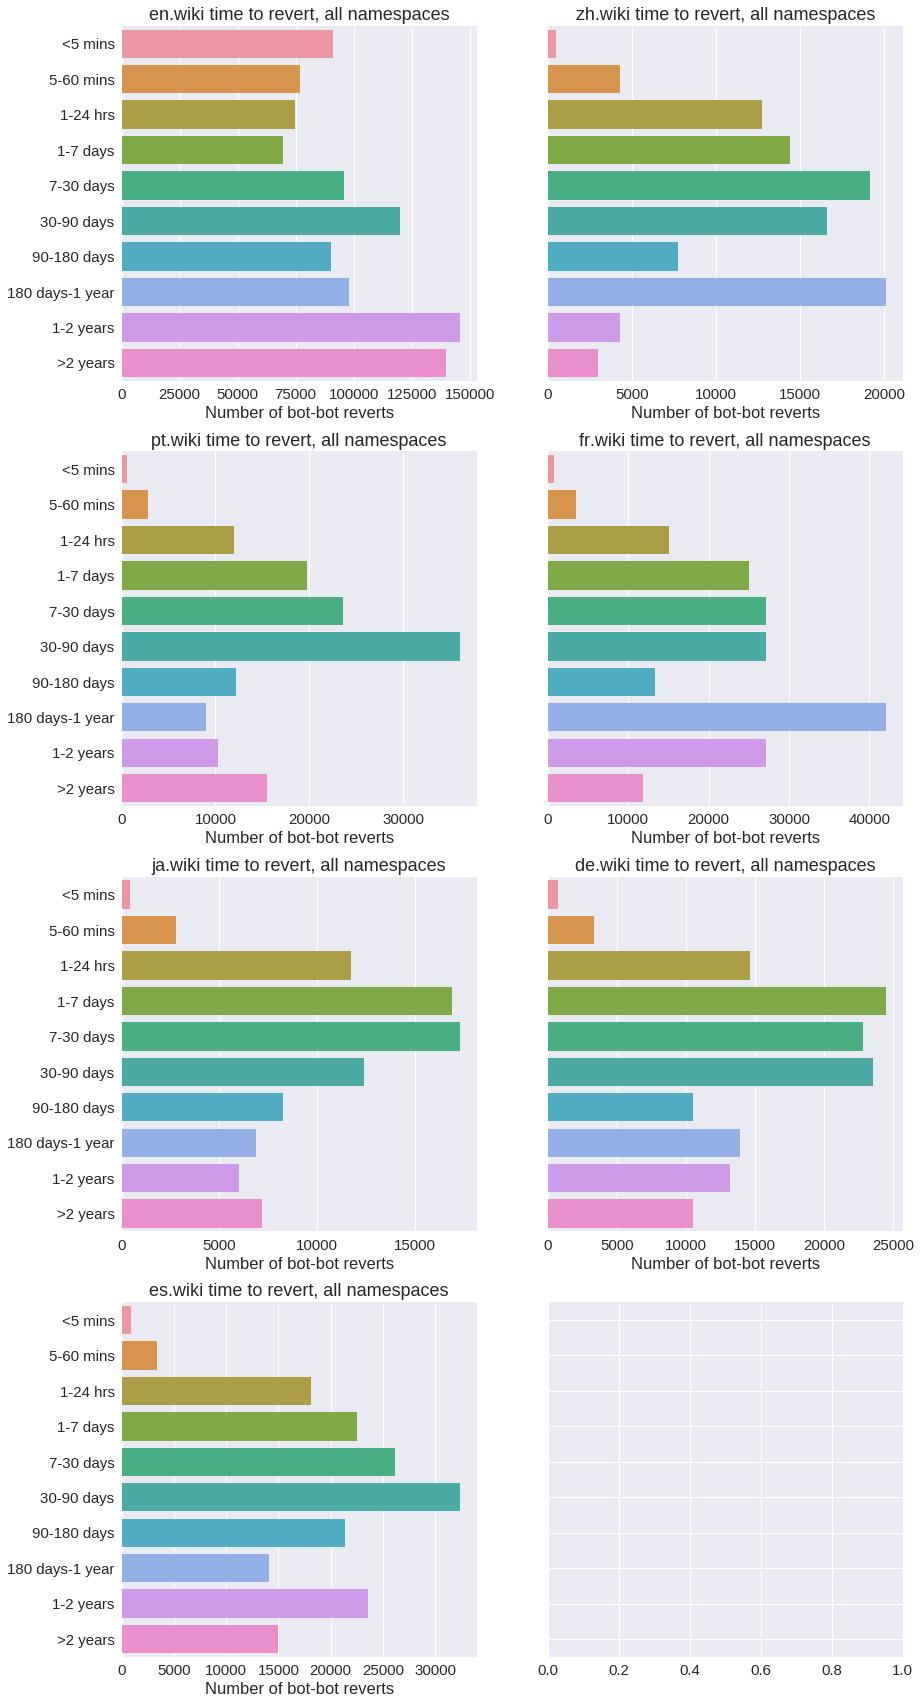

In [122]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=[14,30], sharey=True, sharex=False)

count = 0
for lang, lang_df in df_dict.items():
    row = count // 2
    col = count % 2
    ax_curr = axes[row, col]
    
    hist_counts_curr = hist_counts_dict[lang]
    hist_bins_curr = hist_bins_dict[lang][1:]
    
    sns.barplot(x=hist_counts_curr, y=hist_bins_curr, ax=ax_curr, orient="h")
    txt = ax_curr.set_yticklabels(bin_labels)
    ax_curr.set_xlabel("Number of bot-bot reverts")
    #lt.xticks(rotation='vertical')
    ax_curr.set_title(lang + ".wiki time to revert, all namespaces")
    count = count + 1

#### With shared x axis

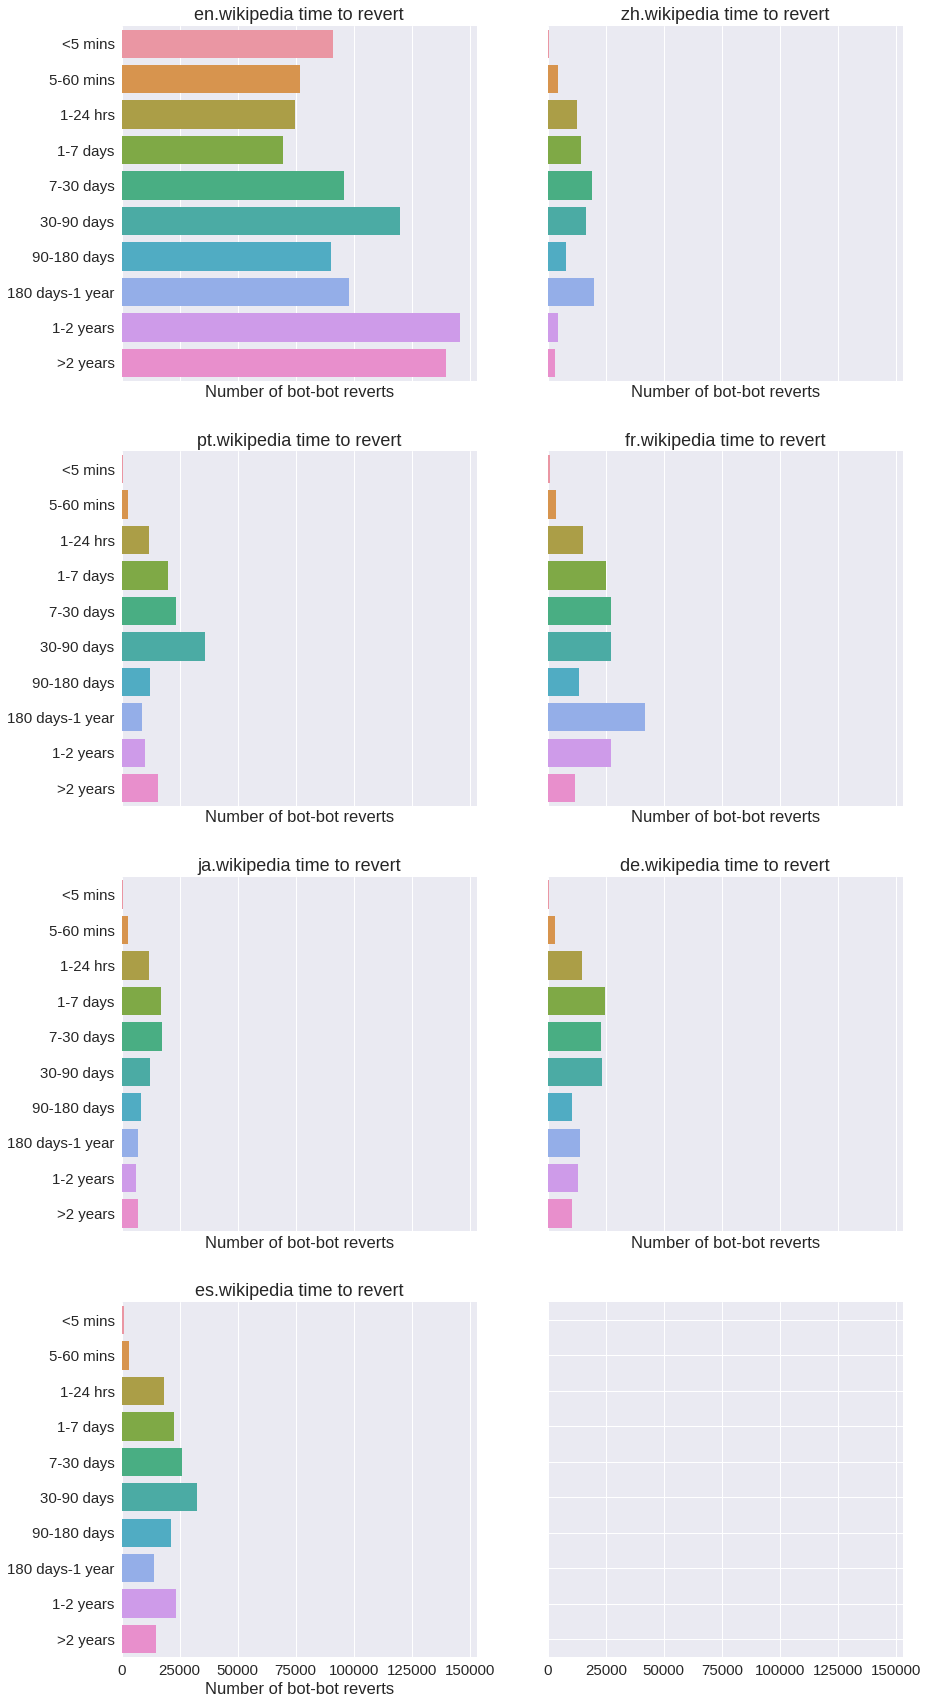

In [123]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=[14,30], sharey=True, sharex=True)

count = 0
for lang, lang_df in df_dict.items():
    row = count // 2
    col = count % 2
    ax_curr = axes[row, col]
    
    hist_counts_curr = hist_counts_dict[lang]
    hist_bins_curr = hist_bins_dict[lang][1:]
    
    sns.barplot(x=hist_counts_curr, y=hist_bins_curr, ax=ax_curr, orient="h")
    txt = ax_curr.set_yticklabels(bin_labels)
    ax_curr.set_xlabel("Number of bot-bot reverts")
    #lt.xticks(rotation='vertical')
    ax_curr.set_title(lang + ".wikipedia time to revert")
    count = count + 1

### Time to revert, all namespaces, enwiki big

In [124]:
bins=[0,(5/60),1,24,(24*7), (24*30), (24*90), (24*180), (24*365), (24*365*2), (25*365*15)]
bin_labels = ["<5 mins",
              "5-60 mins",
              "1-24 hrs",
              "1-7 days",
              "7-30 days",
              "30-90 days",
              "90-180 days",
              "180 days-1 year",
              "1-2 years",
              ">2 years"]
count, division = np.histogram(df_dict['en']['time_to_revert_hrs'], bins=bins)

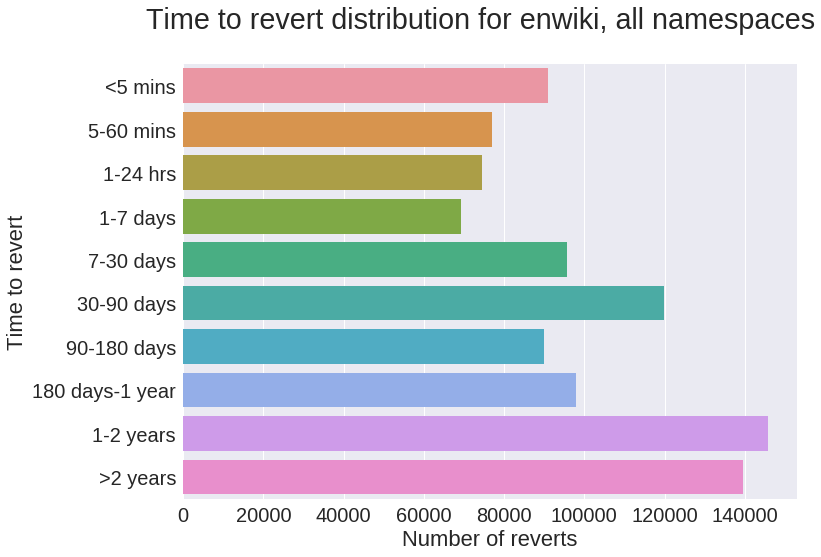

In [125]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=[11,8])
sns.barplot(x=count, y=division[1:], ax=ax, orient="h")
txt = ax.set_yticklabels(bin_labels)
#plt.xticks(rotation='vertical')
ax.set_xlabel("Number of reverts")
ax.set_ylabel("Time to revert")
plt.suptitle("Time to revert distribution for enwiki, all namespaces")

### Time to revert, articles only, fewer bins, enwiki big

In [126]:
bins=[0,(5/60),1,24,(24*7), (24*30), (24*90), (24*180), (24*365), (24*365*2), (24*365*15)]
bin_labels = ["<5 mins",
              "5-60 mins",
              "1-24 hrs",
              "1-7 days",
              "7-30 days",
              "30-90 days",
              "90-180 days",
              "180 days-1 year",
              "1-2 years",
              ">2 years"]

df_en = df_dict['en']
count, division = np.histogram(df_en[df_en['page_namespace']==0]['time_to_revert_hrs'], bins=bins)

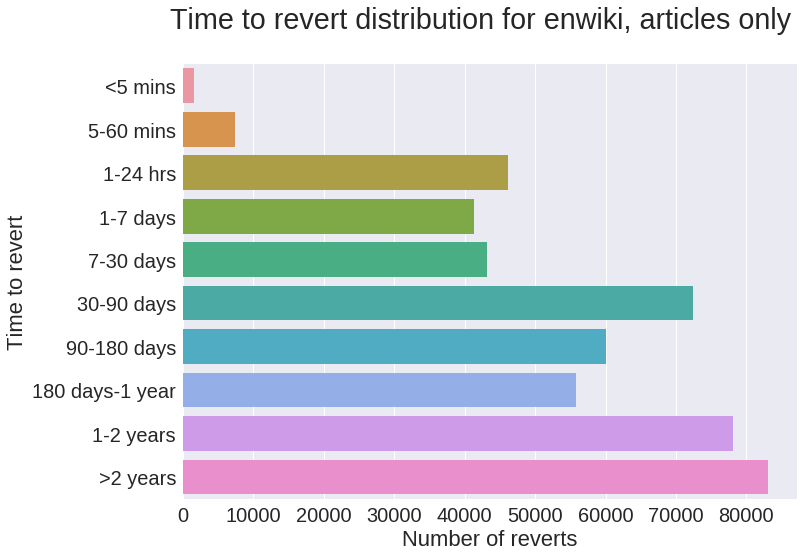

In [127]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=[11,8])
sns.barplot(x=count, y=division[1:], ax=ax, orient="h")
txt = ax.set_yticklabels(bin_labels)
#plt.xticks(rotation='vertical')
ax.set_xlabel("Number of reverts")
ax.set_ylabel("Time to revert")
plt.suptitle("Time to revert distribution for enwiki, articles only")